# Data Ordering attack on Stochastic Gradient Descent


## Motivation

This attack is based on the paper "Manipulating SGD with Data Ordering Attacks" (https://arxiv.org/abs/2104.09667) by Shumailov, Shumaylov, Kazhdan, Zhao, Papernot, Erdogdu and Anderson.


## Explanation

The idea behind this attack is to reorder batches within a data feed to a machine learning model using Stochastic Gradient Descent (SGD). This form of adversarial machine learning exploits SGD's behaviour to attack the model's integrity and availability.


## Simple Attack


### Setup

The attack environment will be using the Abalone Dataset (http://archive.ics.uci.edu/ml) using linear SGD classification with ```sklearn.linear_model.SGDClassifier``` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to predict a tree's number of rings (i.e. its age) based on other features about the tree. \
*Note: The 'sex' feature of the Abalone Dataset has been omitted throughout this algorithm and is not considered by any of the models.*

1. Import necessary libraries.
2. Define configuration values.
3. Load the Abalone Dataset.
4. Apply PCA to the dataset to visualise the data on a 2D plane.
5. Split the dataset into feature vectors ~(tree information) and their corresponsing class labels (the tree's age in years).
6. Initialise control, training and surrogate ```SGDClassifier``` models.
7. Train the models over one epoch for a partial fit of each model with the dataset.

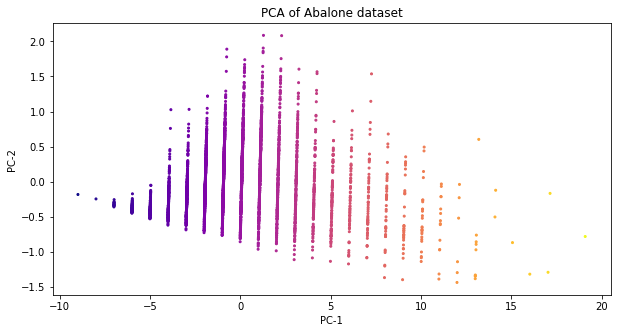

SGDClassifier(eta0=0.2, learning_rate='constant', loss='log', max_iter=100,
              penalty='elasticnet', shuffle=False)

In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Configuration values
HIGH_LOW = 'highlow'
LOW_HIGH = 'lowhigh'
OSC_IN = 'oscillatingin'
OSC_OUT = 'oscillatingout'
BATCH_REORDER = 'reorder'
BATCH_RESHUFFLE = 'reshuffle'
N_TESTDATA_SAMPLES = 150
NUM_ITER = 1000
N = 1476


# Read the abalone.data file into a pandas dataframe
df = pd.read_csv('abalone.data')


# Declare what our feature vectors and class vectors are
features = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
classVector = 'rings'


# Assign a header/title to each feature
df.set_axis(features, axis=1, inplace=True)
features.remove('sex')


# Visualise the data on a 2D plane through PCA dimensionality reduction
pca = PCA(n_components=2)
pcs = pca.fit(df[features]).components_
reducedData = np.matmul((df[features]-df[features].mean()).to_numpy(), pcs.transpose())
dfReduced = pd.DataFrame(data=reducedData, columns=['PC-1', 'PC-2'])
plt.scatter(reducedData[:, 0], reducedData[:, 1], s=4, c=df[classVector].to_list(), cmap='plasma')

plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('PCA of Abalone dataset')
plt.gcf().set_size_inches(10, 5)
plt.show()



# Split dataset into a training dataset and testing dataset
trainingData = df[features][:-N_TESTDATA_SAMPLES]
trainingLabels = df[classVector][:-N_TESTDATA_SAMPLES]

testData = df[features][-N_TESTDATA_SAMPLES:]
testLabels = df[classVector][-N_TESTDATA_SAMPLES:]


# Create identical SGD Classifier control and target models
control = SGDClassifier(loss='log', penalty='elasticnet', max_iter=100, tol=0.001, shuffle=False, learning_rate='constant', eta0=0.2)
target = SGDClassifier(loss='log', penalty='elasticnet', max_iter=100, tol=0.001, shuffle=False, learning_rate='constant', eta0=0.2)


# Surrogate model which the attacker is using to predict Iris classification, different configuration to the control/target models
surrogate = SGDClassifier(loss='hinge', max_iter=90, tol=0.001, shuffle=False, learning_rate='constant', eta0=0.2)


# Get a numpy array of all possible class labels in dataset
classLabels = np.unique(df[classVector].to_numpy())


# Train the models over one epoch of datapoints in a currently natural non-malicious order
control.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)
surrogate.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)
target.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)



### Reorder data to attack

The data is reordered based on the specified attack type and the data is then fed in this order into the target and surrogate models. The control model's ordering is not altered by the algorithm. This model is not needed in an actual attack and is only being used in this experiment as a control model for data analysis and comparison after running the algorithm.

This is repeated ```NUM_ITER``` times, with the change in accuracy between target and control models being recorded at every iteration.


In [19]:

# Utility method to determine if SGDClassifier classification was accurate or not
def accuracy(x, y):
    return x == y


#===== ATTACK =====
def attack(attackType, batchType):

    datapoints = []
    datatargets = []
    datacosts = {}

    for i in range(len(trainingData)):
        # Read each datapoint, evaluate the accuracy, record these values
        point = trainingData.iloc[i:i+1]
        label = trainingLabels.iloc[i]
        loss = hinge_loss(surrogate.predict(point), [label])
        datapoints.append(point)
        datatargets.append(label)
        datacosts[i] = loss

    
    # Reorder datapoint indecies by ascending order of loss
    reorderedCosts = dict(sorted(datacosts.items(), key = lambda item: item[1]))

    reorderedData = []
    reorderedLabels = []

    for index in reorderedCosts:
        # Reorder datapoints and their classes based on redordered indecies
        reorderedData.append(datapoints[index])
        reorderedLabels.append(datatargets[index])

    reorderedData = pd.concat(reorderedData)

    #START OF TO BE COMPLETED WORK
    if attackType == HIGH_LOW:
        # Reverse order of reordered data if high -> low attack type
        reorderedData = [reorderedData[0][::-1], reorderedData[1][::-1], reorderedData[2][::-1]]
        reorderedLabels = reorderedLabels[::-1]

    if attackType == OSC_OUT:
        # Invert each half of reordered data if oscillating out attack type
        right = reorderedData[len(reorderedData)//2:][::-1]
        left = reorderedData[:len(reorderedData)//2][::-1]
        reorderedData = left + right

        right = reorderedLabels[len(reorderedLabels)//2:][::-1]
        left = reorderedLabels[:len(reorderedLabels)//2][::-1]
        reorderedLabels = left + right
    #END OF TO BE COMPLETED WORK
    
    control.partial_fit(X=trainingData, y=trainingLabels)
    target.partial_fit(X=reorderedData, y=np.ravel(reorderedLabels))
    surrogate.partial_fit(X=reorderedData, y=np.ravel(reorderedLabels))

accuracies = []

for i in range(NUM_ITER):
    attack(LOW_HIGH, None)
    accuracies.append(control.score(testData, testLabels) - target.score(testData, testLabels))


### Data Analysis

1. Plot a graph of the difference in accuracy between control and target models versus the number of iterations (epochs) of training on the model.
2. Output the epoch with the largest accuracy change. 

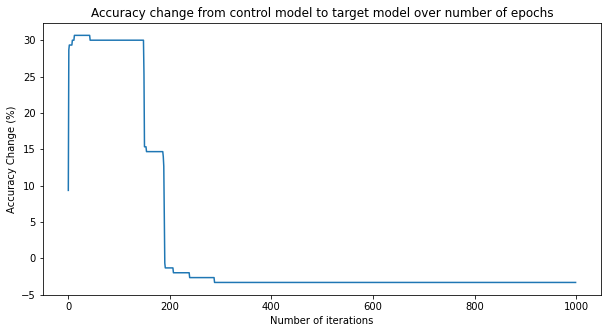

The peak accuracy change is identified after 13 epochs with an accuracy change of 30.67%.


In [20]:
# Multiply accuracy change values by 100 for percentages
percentageAcc = np.array(accuracies) * 100

# Plot graph of accuracy variation with number of iterations during training
plt.plot(range(NUM_ITER), percentageAcc)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy Change (%)')
plt.title('Accuracy change from control model to target model over number of epochs')
plt.gcf().set_size_inches(10, 5)
plt.show()
print("The peak accuracy change is identified after " + str(np.argmax(percentageAcc) + 1) + " epochs with an accuracy change of " + str(np.round(np.max(percentageAcc), 2)) + "%.")